# Introduction


**Pandega Abyan Zumarsyah (23/526264/PTK/15434)**

Notebook ini merupakan proyek _Image Enhancement_ pada citra tertentu dengan metode tertentu.
Citranya adalah citra fundus retina sementara metode utamanya berdasarkan referensi "_Retinex-Like Method for Image Enhancement in Poor Visibility Conditions_" oleh Hao et al.
Metode _Retinex-like Enhancement_ itu diimplementasikan secara mandiri utamanya dengan library NumPy.
Metode itu juga dibandingkan dengan beberapa metode _Image Enhancement_ konvensional, yaitu peningkatan kecerahan, _histogram equalization_, CLAHE, dan _gamma correction_.

Sebagai catatan, referensi yang lain, "_Improved Retinex Image Enhancement Algorithm_" oleh Tang et al., tidak dipakai karena metodenya didesain untuk citra _multi-frame_ seperti video.
Selain itu, pendekatan dengan mengubah ke logaritmik untuk melakukan perkalian juga kurang jelas (kenapa harus diubah ke logaritmik lalu penjumlahan, kenapa tidak langsung perkalian saja).


# Initialization


## Module Import


In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2


## Generic Functions


In [2]:
def convert_to_float32(image):
    if image.dtype == np.uint8:
        return image.astype(np.float32) / 255
    return image


def clip_float32(image):
    return np.clip(image, 0, 1)


def read_rgb_image(image_path):
    return convert_to_float32(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))


def resize_image(image, scale):
    return cv2.resize(image, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)


def pad_image(image, pad_width, pad_value=None):
    def pad_with(vector, width, iaxis, kwargs):
        value = kwargs.get("padder")
        if value is None:
            value = np.nan
        vector[: width[0]] = value
        vector[-width[1] :] = value

    return np.pad(image, pad_width, pad_with, padder=pad_value)

In [3]:
def plot_single_image(image, title="", cmap="gray"):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_multiple_images(images, titles, size, cmap="gray", scale=0.7):
    figsize = (
        int(size[1] * images[0].shape[1] * scale * 0.01),
        int(size[0] * images[0].shape[0] * scale * 0.01),
    )
    fig, axes = plt.subplots(size[0], size[1], figsize=figsize)
    fig.tight_layout()
    axes = axes.flatten()
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

# Algorithm and Functions


## RGB HSV Conversion


In [4]:
def rgb_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)


def hsv_to_rgb(image):
    return clip_float32(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))

## Bilateral Filter


Ini merupakan bagian penting dari algoritma _Retinex-like Enhancement_ sehingga diimplementasikan secara mandiri dengan NumPy.
Awalnya, implementasi dilakukan secara iteratif, _pixel by pixel_, sesuai formula yang disajikan pada _paper_.
Operasi pada _single pixel_ ada pada fungsi `bilateral_filter_point` sementara operasi iteratif pada banyak piksel ada pada fungsi `bilateral_filter_loop`.


In [5]:
def bilateral_filter_point(image, i, j, neighbor_param, spatial_param, intensity_param):
    point_intensity = image[i, j]

    left_top_limit = max(0, i - neighbor_param)
    left_bottom_limit = min(image.shape[0], i + neighbor_param + 1)
    right_top_limit = max(0, j - neighbor_param)
    right_bottom_limit = min(image.shape[1], j + neighbor_param + 1)
    neighbor = image[
        left_top_limit:left_bottom_limit, right_top_limit:right_bottom_limit
    ]
    neighbor_index = np.mgrid[
        left_top_limit:left_bottom_limit, right_top_limit:right_bottom_limit
    ]

    spatial_norm = (neighbor_index[0] - i) ** 2 + (neighbor_index[1] - j) ** 2
    intensity_norm = (neighbor - point_intensity) ** 2

    spatial_val = -spatial_norm / (2 * spatial_param**2)
    intensity_val = -intensity_norm / (2 * intensity_param**2)
    exp_val = np.exp(spatial_val + intensity_val)

    numerator = np.sum(exp_val * neighbor) - point_intensity
    denumerator = np.sum(exp_val) - (1 - 0.0001)

    return numerator / denumerator

In [6]:
def bilateral_filter_loop(image, neighbor_param, spatial_param, intensity_param):
    new_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_image[i, j] = bilateral_filter_point(
                image, i, j, neighbor_param, spatial_param, intensity_param
            )
    return new_image

Implementasi iteratif itu terbukti sangat lambat dan tidak efisien.
Karenanya, dibuatlah implementasi baru dengan mengubah konsep iteratif menjadi perkalian matriks ukuran besar.
Dibanding implementasi iteratif, implementasi baru ini jauh lebih cepat, tetapi butuh lebih banyak RAM.
Meski begitu, implementasi baru ini sudah dioptimasi untuk mengurangi penggunaan RAM dan mempercepat komputasi, misalnya dengan menggunakan sedikit sekali _intermediate variable_.
Karena sudah dioptimasi, kodenya mungkin tidak mudah untuk dipahami.
Bagaimana pun, formula yang digunakan tetap sama, hasilnya juga bisa dikatakan sama.


In [7]:
def bilateral_filter(image, neighbor_param, spatial_param, intensity_param):
    row_index, col_index = np.indices(image.shape, dtype=np.int16)
    row_index_padded = pad_image(row_index.astype(np.float16), neighbor_param)
    col_index_padded = pad_image(col_index.astype(np.float16), neighbor_param)
    image_padded = pad_image(image, neighbor_param)

    neighbor_index = np.fromfunction(
        lambda ax, i, j, i_n, j_n: np.where(ax == 0, i + i_n, j + j_n),
        (2,) + image.shape + (2 * neighbor_param + 1,) * 2,
        dtype=np.int8,
    )
    neighbor_intensity = image_padded[neighbor_index[0], neighbor_index[1]]

    exp_term = np.exp(
        -(
            (
                row_index_padded[neighbor_index[0], neighbor_index[1]]
                - row_index[..., None, None]
            )
            ** 2
            + (
                col_index_padded[neighbor_index[0], neighbor_index[1]]
                - col_index[..., None, None]
            )
            ** 2
        )
        / (2 * spatial_param**2)
        - ((neighbor_intensity - image[..., None, None]) ** 2)
        / (2 * intensity_param**2)
    )

    numerator = np.nansum(exp_term * neighbor_intensity, axis=(2, 3)) - image
    denumerator = np.nansum(exp_term, axis=(2, 3)) - (1 - 0.0001)

    return numerator / denumerator

Kode berikut menunjukan bagaimana implementasi yang sudah dioptimasi jauh lebih cepat dibanding implementasi iteratif, lebih dari 20 kali lebih cepat.
Meski begitu, hasil keduanya tidak berbeda jauh.
Ketika dibulatkan ke empat angka di belakang koma, hampir semua nilainya sama.


In [8]:
dummy_image = np.random.rand(100, 100).astype(np.float32)
neighbor_param = 2
spatial_param = 5
intensity_param = 0.5

start_time = time.perf_counter()
optimized_result = bilateral_filter(
    dummy_image, neighbor_param, spatial_param, intensity_param
)
print("Optimized", time.perf_counter() - start_time)

start_time = time.perf_counter()
loop_result = bilateral_filter_loop(
    dummy_image, neighbor_param, spatial_param, intensity_param
)
print("Loop", time.perf_counter() - start_time)

print(
    "Same?",
    np.unique(
        np.round(optimized_result, 5) == np.round(loop_result, 5), return_counts=True
    ),
)

Optimized 0.07553650019690394


Loop 2.7024755999445915
Same? (array([False,  True]), array([  38, 9962], dtype=int64))


## Gamma Correction


Fungsi `gamma_correction` adalah fungsi _gamma correction_ biasa sementara fungsi `dynamic_gamma_correction` adalah fungsi modifikasi sesuai yang ada pada _paper_.


In [9]:
def gamma_correction(image, gamma):
    return clip_float32(image ** (1 / gamma))

In [10]:
def dynamic_gamma_correction(image, param):
    gamma = image * param + param
    return gamma_correction(image, gamma)

## Retinex-like Enhancement


Sesuai pada _paper_, alur algoritmanya:

-   konversi ke HSV
-   ambil V nya
-   ubah ke logaritmik dengan log
-   cari gain & offset dari hasil log
-   terapkan filter bilateral
-   modifikasi nilainya dengan aritmatika sederhana tertentu
-   kembalikan ke linear dengan exp
-   gabungkan V baru dengan H & S
-   konversi balik ke RGB
-   _gamma correction_


In [11]:
def get_gain_and_offset(image):
    max_value = image.max()
    min_value = image.min()
    gain = 3 / (max_value - min_value)
    offset = -max_value * gain
    return gain, offset

In [12]:
def retinex_like_enhancement(
    image, bf_neighbor=1, bf_spatial=1, bf_intensity=1, gamma_param=0.6
):
    image_hsv = rgb_to_hsv(image)
    v_channel = image_hsv[:, :, 2]
    v_log = np.log(v_channel + 0.0001)
    v_filter = bilateral_filter(v_log, bf_neighbor, bf_spatial, bf_intensity)
    gain, offset = get_gain_and_offset(v_filter)
    v_log_new = v_log + (gain - 1) * v_filter + offset
    v_channel_new = np.exp(v_log_new)
    image_hsv_new = np.stack(
        [image_hsv[:, :, 0], image_hsv[:, :, 1], v_channel_new], axis=-1
    )
    image_new = hsv_to_rgb(image_hsv_new)
    image_final = dynamic_gamma_correction(image_new, gamma_param)
    return image_final

## HSV Value Update


Ini fungsi sederhana untuk mengubah nilai V dari HSV, bisa untuk mengatur kecerahan.


In [13]:
def hsv_value_update(image, delta):
    image_hsv = rgb_to_hsv(image)
    image_hsv[:, :, 2] += delta
    image_new = hsv_to_rgb(image_hsv)
    return image_new

## Histogram Equalization


Ini fungsi sederhana untuk _histogram equalization_ pada _channel_ R & G & B secara terpisah.


In [14]:
def histogram_equalization(image):
    result = np.zeros_like(image)
    for i in range(3):
        result[:, :, i] = (
            cv2.equalizeHist((image[:, :, i] * 255).astype(np.uint8)) / 255
        )
    return result

## Apply CLAHE


Ini fungsi sederhana untuk penerapan CLAHE (Contrast Limited Adaptive Histogram Equalization) pada _channel_ R & G & B secara terpisah.


In [15]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    result = np.zeros_like(image)
    for i in range(3):
        if isinstance(clip_limit, list):
            cl = clip_limit[i]
        else:
            cl = clip_limit
        clahe = cv2.createCLAHE(cl, tile_grid_size)
        result[:, :, i] = clahe.apply((image[:, :, i] * 255).astype(np.uint8)) / 255
    return result

# Implementations


## Image Read


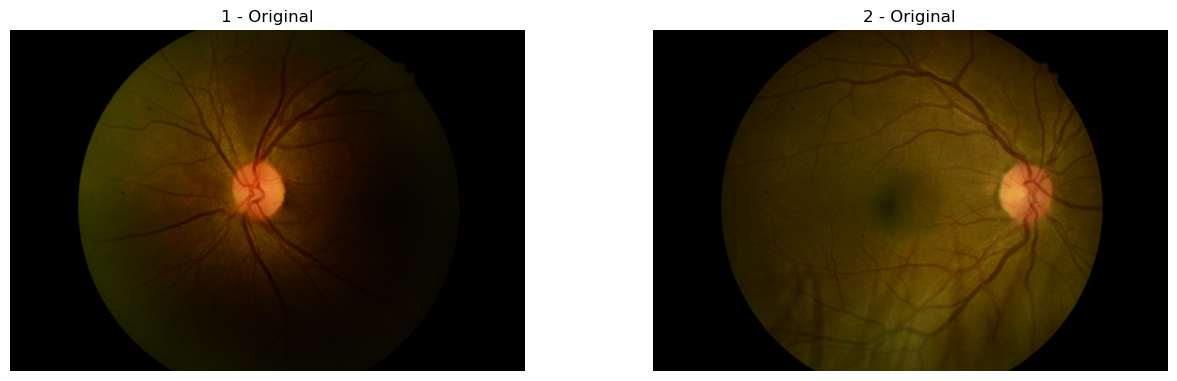

Data 1 (653, 986, 3) float32
Data 2 (653, 986, 3) float32


In [16]:
img1 = read_rgb_image("Data 1.JPG")
img1 = resize_image(img1, 0.2)

img2 = read_rgb_image("Data 2.JPG")
img2 = resize_image(img2, 0.2)

plot_multiple_images([img1, img2], ["1 - Original", "2 - Original"], (1, 2))
print("Data 1", img1.shape, img1.dtype)
print("Data 2", img2.shape, img2.dtype)

Citra perlu dikecilkan agar pengolahan selanjutnya lebih ringan.
Dari Gambar, terlihat bahwa kedua citra cenderung gelap sehingga beberapa bagian pembuluh darah kurang terlihat.
_Image Enhancement_ bisa digunakan untuk membuat citra bagian tertentu menjadi lebih cerah tanpa mengorbankan bagian citra yang sudah cerah.


## Retinex-like Method Exploration


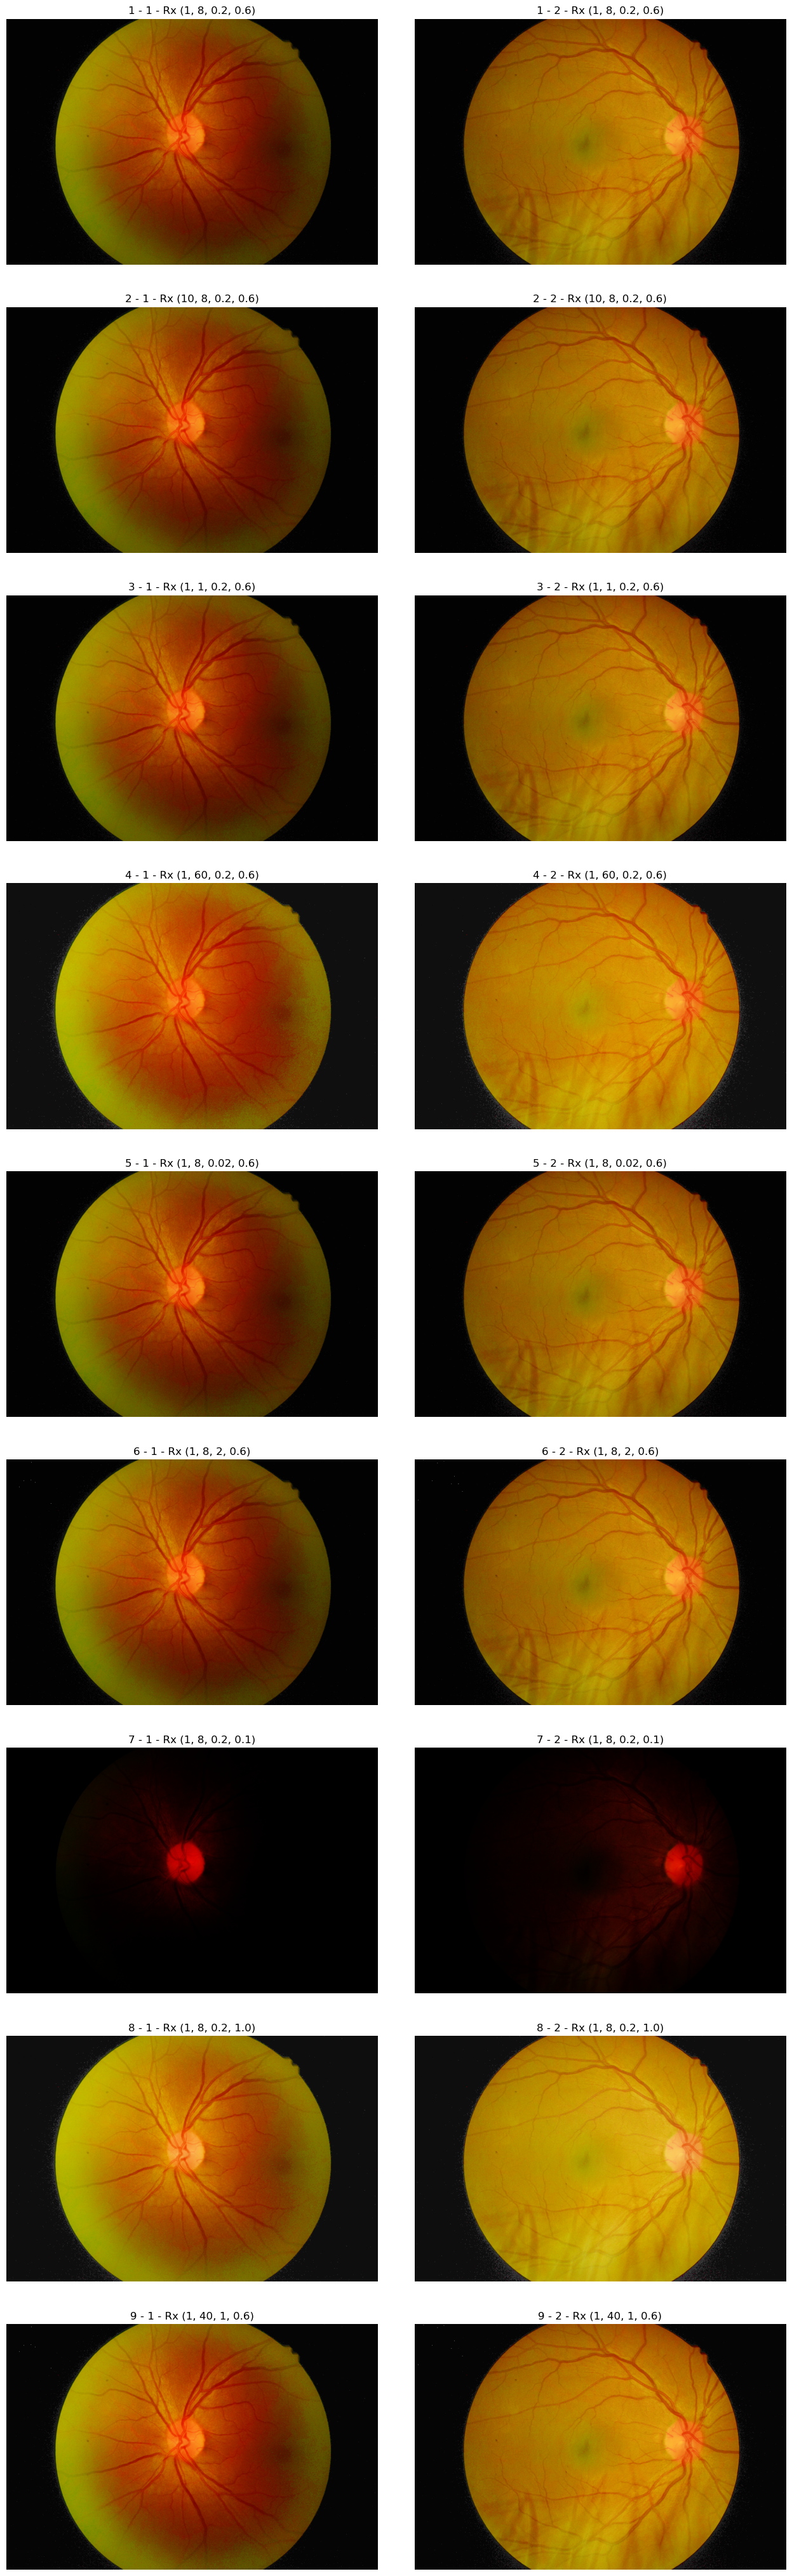

In [22]:
retinex_params = [
    (1, 8, 0.2, 0.6),
    (10, 8, 0.2, 0.6),
    (1, 1, 0.2, 0.6),
    (1, 60, 0.2, 0.6),
    (1, 8, 0.02, 0.6),
    (1, 8, 2, 0.6),
    (1, 8, 0.2, 0.1),
    (1, 8, 0.2, 1.0),
    (1, 40, 1, 0.6),
]

images = []
titles = []
for i, param in enumerate(retinex_params):
    img1_retinex = retinex_like_enhancement(img1, *param)
    img2_retinex = retinex_like_enhancement(img2, *param)
    images.extend([img1_retinex, img2_retinex])
    titles.extend([f"{i+1} - 1 - Rx {param}", f"{i+1} - 2 - Rx {param}"])

plot_multiple_images(images, titles, (len(retinex_params), 2))

Eksplorasi dilakukan dengan menguji berbagai nilai parameter untuk _"Retinex-like Enhancement"_.
Parameternya ada empat, tiga terkait filter bilateral (_neighbor_, parameter _spatial_, dan parameter _intensity_) sementara satunya adalah parameter \*gamma\*.
Hasil eksplorasi:

-   Baris 1 menggunakan parameter _default_ dari _paper_ dengan _neighbor_-nya diatur minimalis. Ini menjadi _baseline_ untuk baris lainnya.
-   Dari baris 1 dan 2, terlihat bahwa hasilnya mirip meski _neighbor_-nya berbeda jauh. Padahal, besarnya _neighbor_ itu sangat mempengaruhi beratnya komputasi. Dengan demikian, _neighbor_ sebaiknya diatur minimalis saja.
-   Dari baris 1 dan 3 & 4, terlihat bahwa parameter _spatial_ berkorelasi positif dengan kecerahan, meski butuh nilai tinggi agar efeknya terasa.
-   Dari baris 1 dan 5 & 6, terlihat bahwa parameter _intensity_ juga berkorelasi positif dengan kecerahan, meski kurang terlihat jelas bedanya.
-   Dari baris 1 dan 7 & 8, terlihat bahwa besarnya parameter _gamma_ sangat mempengaruhi kecerahan, tetapi jika terlalu besar akan membuat detail citra menjadi kurang jelas.
-   Baris 9 merupakan hasil yang sudah di-_tuning_ sehingga memiliki kecerahan yang sesuai tanpa menghilangkan detail penting dari citra. Hasilnya mirip baris 1, tetapi lebih cerah dan lebih jelas.


## Retinex-like Method vs Conventional Methods


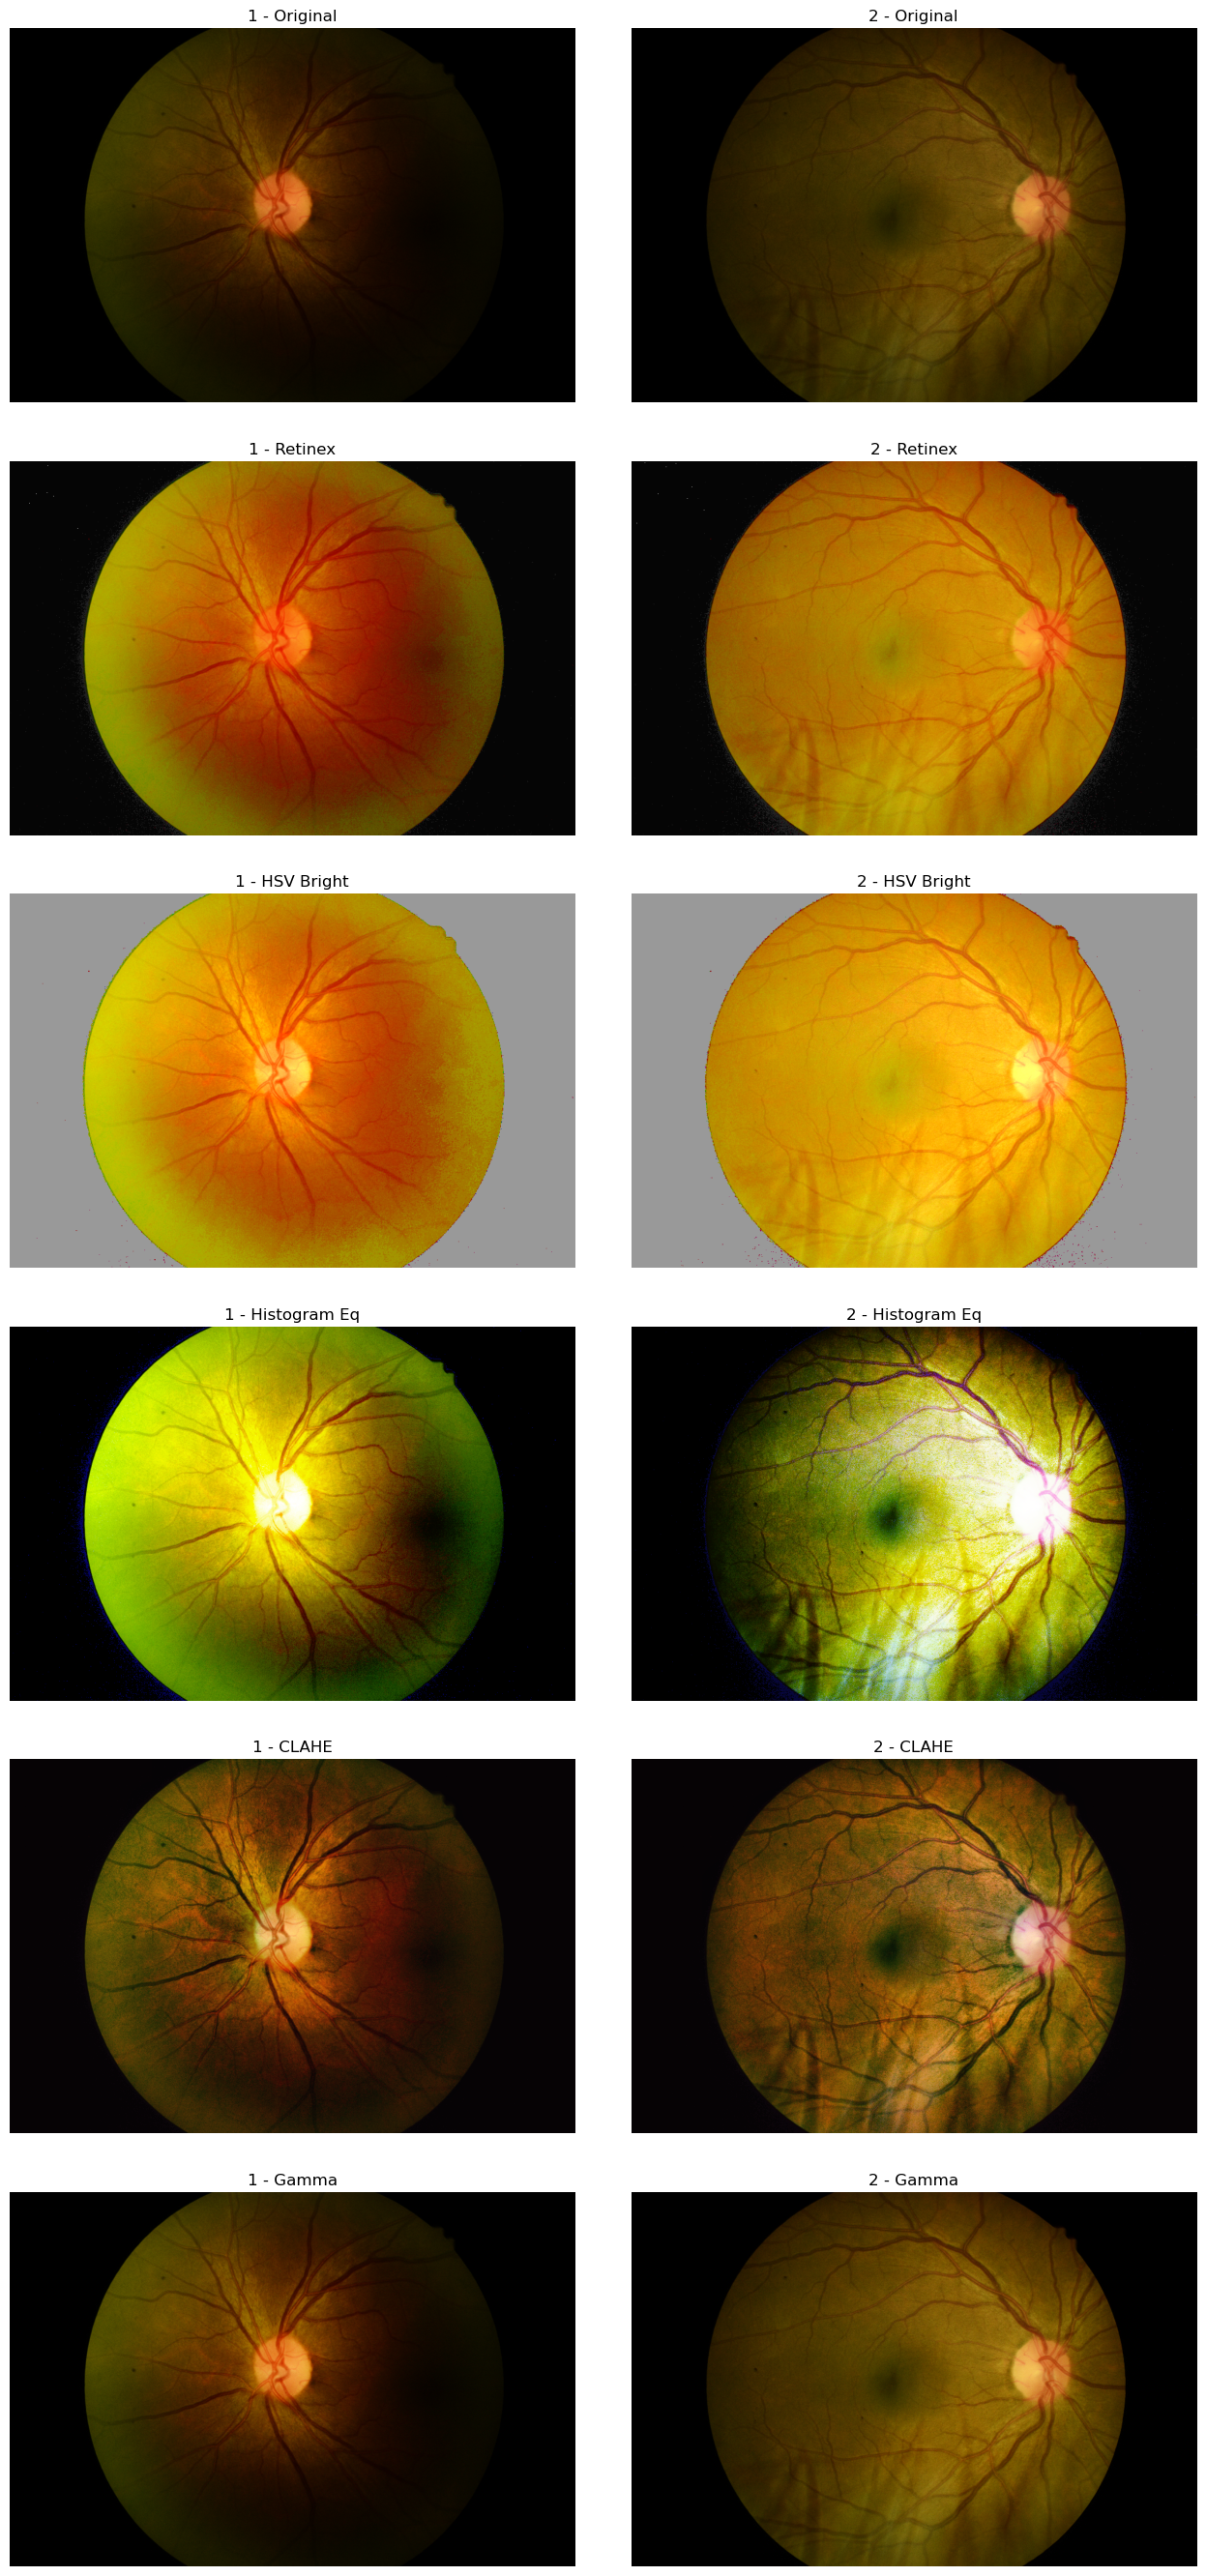

In [20]:
images = [
    img1,
    img2,
    retinex_like_enhancement(img1, 1, 40, 1, 0.6),
    retinex_like_enhancement(img2, 1, 40, 1, 0.6),
    hsv_value_update(img1, 0.6),
    hsv_value_update(img2, 0.6),
    histogram_equalization(img1),
    histogram_equalization(img2),
    apply_clahe(img1, [5, 2, 4]),
    apply_clahe(img2, [5, 2, 4]),
    dynamic_gamma_correction(img1, 1),
    dynamic_gamma_correction(img2, 1),
]
titles = [
    "1 - Original",
    "2 - Original",
    "1 - Retinex",
    "2 - Retinex",
    "1 - HSV Bright",
    "2 - HSV Bright",
    "1 - Histogram Eq",
    "2 - Histogram Eq",
    "1 - CLAHE",
    "2 - CLAHE",
    "1 - Gamma",
    "2 - Gamma",
]

plot_multiple_images(images, titles, (len(images) // 2, 2))

Setelah didapatkan hasil terbaik dengan _Retinex-like Enhancement_, terdapat perbandingan dengan berbagai metode lain yang lebih sederhana dan konvensional.
Berbagai metode lain itu juga sudah di-_tuning_ agar hasilnya cukup baik.

Update nilai V pada HSV memang bisa meningkatkan kecerahan dengan mudah, tetapi semua piksel terkena dampaknya. Di antara efek ngatifnya: area yang hitam menjadi abu, _noise_ di tepi menjadi terlihat, area di tengah yang cerah menjadi terlalu cerah sehingga detailnya kurang terlihat.

_Histogram Equalization_ pada tiga _channel_ RGB sangat tidak cocok untuk kasus ini. Terlihat hasilnya sangat berbeda dari citra asli dan sulit diinterpretasikan. CLAHE sebenarnya juga memberikan hasil yang kurang baik, tetapi CLAHE memiliki beberapa parameter yang bisa di-_tuning_ agar hasilnya lebih baik. Meski begitu, _tuning_ tidaklah mudah dan algoritma CLAHE juga memiliki berbagai kelemahan

_Gamma Correction_ juga sangat mempengaruhi kecerahan, tetapi perubahan tingkat kecerahannya terkadang kurang sesuai, yang cerah banyak bertambah cerah sementara yang gelap sedikit saja bertambah cerah.

Dengan demikian, secara umum, dapat dikatakan bahwa _Retinex-like Enhancement_ bisa bersaing dengan metode lain yang konvensional.
Hasilnya secara umum lebih baik, tetapi beban komputasinya lebih besar.
